In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import torch
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time

import neural_network_lyapunov
import neural_network_lyapunov.relu_system as relu_system
import neural_network_lyapunov.lyapunov as lyapunov
import neural_network_lyapunov.encoders as encoders
import neural_network_lyapunov.pybullet_data_generation as pybullet_data_generation
import neural_network_lyapunov.dynamics_learning as dynamics_learning

In [26]:
folder = "experiments/cubes"

sys.path.insert(0, os.path.join(os.path.dirname(neural_network_lyapunov.__file__), "..", "notebooks", folder))
import options
opt = dynamics_learning.DynamicsLearningOptions(options.default)

In [27]:
x_data = torch.load(os.path.join(folder, "x_data"))
x_next_data = torch.load(os.path.join(folder, "x_next_data"))
X_data = torch.load(os.path.join(folder, "X_data"))
X_next_data = torch.load(os.path.join(folder, "X_next_data"))
x_val = torch.load(os.path.join(folder, "x_val"))
x_next_val = torch.load(os.path.join(folder, "x_next_val"))
X_val = torch.load(os.path.join(folder, "X_val"))
X_next_val = torch.load(os.path.join(folder, "X_next_val"))
x_long_horizon_rollouts = torch.load(os.path.join(folder, "x_long_horizon_rollouts"))
X_long_horizon_rollouts = torch.load(os.path.join(folder, "X_long_horizon_rollouts"))

In [28]:
x_train_dataloader = pybullet_data_generation.get_dataloader(x_data, x_next_data, opt.batch_size)
x_validation_dataloader = pybullet_data_generation.get_dataloader(x_val, x_next_val, opt.batch_size)
X_train_dataloader = pybullet_data_generation.get_dataloader(X_data, X_next_data, opt.batch_size)
X_validation_dataloader = pybullet_data_generation.get_dataloader(X_val, X_next_val, opt.batch_size)

## State space

In [18]:
trained_learners = {}
for variant in options.variants.keys():
# for variant in ['stable', 'unstable']:
    var_opt = dynamics_learning.DynamicsLearningOptions(options.default)
    var_opt.set_options(options.variants[variant])
    learner = dynamics_learning.StateSpaceDynamicsLearning.load(os.path.join(folder, variant), 
                                                                x_train_dataloader, x_validation_dataloader,
                                                                var_opt)
    trained_learners[variant] = learner

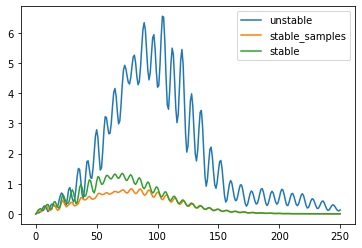

In [24]:
# validation over rollouts
legend = []
for variant in trained_learners.keys():
# for variant in ['stable', 'stable_samples']:
# for variant in ['stable', 'unstable']:
# for variant in ['stable_samples', 'unstable']:
    learner = trained_learners[variant]
    plt.plot(learner.rollout_validation(x_long_horizon_rollouts[:15], device=learner.opt.device))
    legend.append(variant)
plt.legend(legend)
plt.show()

In [22]:
unstable_learner = trained_learners["unstable"]
pbsg = pybullet_data_generation.PybulletSampleGenerator(unstable_learner.opt.world_cb, unstable_learner.opt.joint_space,
                                                        image_width=unstable_learner.opt.image_width, image_height=unstable_learner.opt.image_height,
                                                        grayscale=unstable_learner.opt.grayscale,
                                                        camera_eye_position=unstable_learner.opt.camera_eye_position,
                                                        camera_target_position=unstable_learner.opt.camera_target_position,
                                                        camera_up_vector=unstable_learner.opt.camera_up_vector,
                                                        dtype=unstable_learner.opt.dtype)

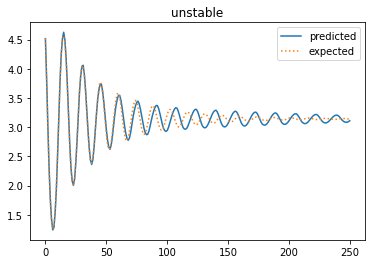

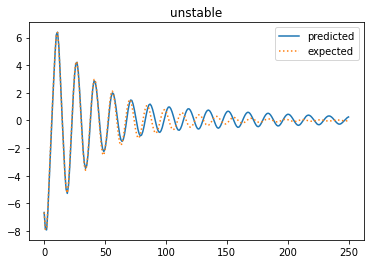

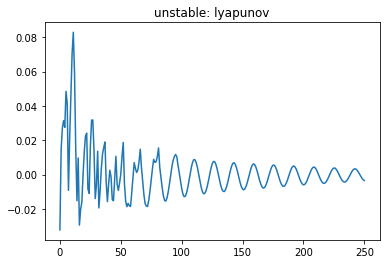

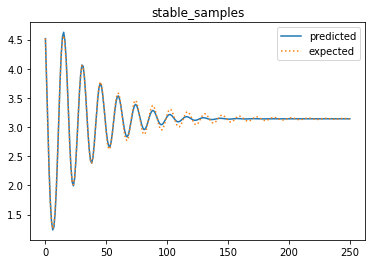

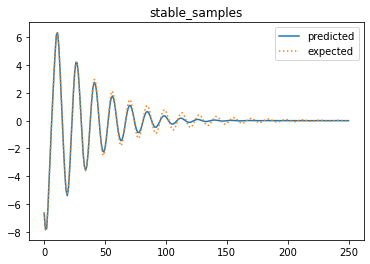

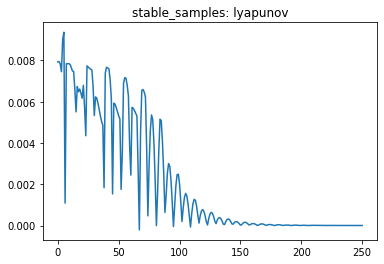

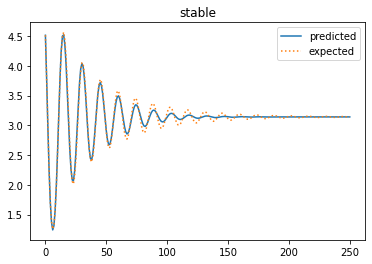

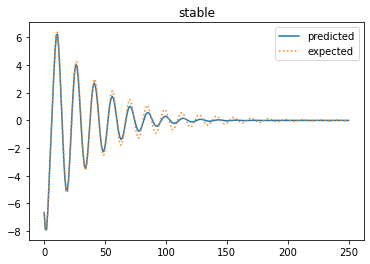

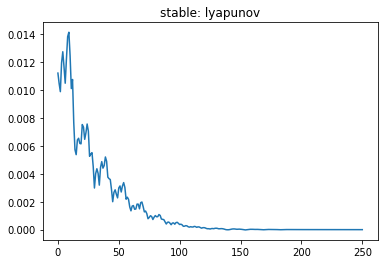

In [25]:
legend = []
# i = np.random.choice(x_data.shape[0], 1)[0]
# x0 = x_data[i, :]
i = np.random.choice(x_val.shape[0], 1)[0]
x0 = x_val[i, :]
for variant in trained_learners.keys():
    learner = trained_learners[variant]
    x_traj, V_traj = learner.rollout(x0, learner.opt.long_horizon_N)
    x_traj_exp, _ = pbsg.generate_rollout(x0, learner.opt.dataset_dt, learner.opt.long_horizon_N)
    for j in range(x_traj.shape[1]):
        plt.plot(x_traj[:, j])
        plt.plot(x_traj_exp[:, j], ':')
        plt.legend(['predicted', 'expected'])
        plt.title(variant)
        plt.show()
    plt.plot(V_traj)
    plt.title(variant + ": lyapunov")
    plt.show()

In [ ]:
# train the lyapunov of the unstable system
unstable_learner = trained_learners["unstable"]
unstable_learner.reset_optimizer(lyapunov_only=True)
unstable_learner.opt.set_option("lyap_loss_freq", 1)
unstable_learner.opt.set_option("lyap_pos_loss_at_samples_weight", 1)
unstable_learner.opt.set_option("lyap_der_loss_at_samples_weight", 1)
unstable_learner.opt.set_option("lyap_pos_loss_weight", 1)
unstable_learner.opt.set_option("lyap_der_loss_weight", 1)

In [ ]:
unstable_learner.train(50, validate=False, device=unstable_learner.opt.device)

In [ ]:
# saving the new lyapunov
unstable_learner.save(os.path.join(folder, variant + "_trained_lyapunov"))

In [ ]:
# compute adversarial examples for the unstable system
unstable_learner.opt.set_option("lyap_loss_optimal", True)
x_adv_pos, x_adv_der = unstable_learner.adversarial_samples()
x_adv = torch.cat((x_adv_pos, x_adv_der), dim=0)
print(x_adv)

In [ ]:
stable_learner = trained_learners["stable_samples"]
# stable_learner = trained_learners["stable"]
stable_learner.opt.set_option("lyap_loss_optimal", False)
x_adv_pos, x_adv_der = stable_learner.adversarial_samples()
x_adv = torch.cat((x_adv_pos, x_adv_der), dim=0)
print(x_adv)

In [ ]:
legend = []
# i = np.random.choice(x_adv.shape[0], 1)[0]
for i in range(x_adv.shape[0]):
    print("adversarial sample: " + str(i))
    x0 = x_adv[i, :]
    for variant in trained_learners.keys():
        learner = trained_learners[variant]
        x_traj, V_traj = learner.rollout(x0, learner.opt.long_horizon_N)
        x_traj_exp, _ = pbsg.generate_rollout(x0, learner.opt.dataset_dt, learner.opt.long_horizon_N)
        for j in range(x_traj.shape[1]):
            plt.plot(x_traj[:, j])
            plt.plot(x_traj_exp[:, j], ':')
            plt.legend(['predicted', 'expected'])
            plt.title(variant)
            plt.show()
        plt.plot(V_traj)
        plt.title(variant + ": lyapunov")
        plt.show()
    print("************")

## Image space

In [29]:
trained_learners = {}
for variant in options.variants.keys():
    var_opt = dynamics_learning.DynamicsLearningOptions(options.default)
    var_opt.set_options(options.variants[variant])
    learner = dynamics_learning.LatentSpaceDynamicsLearning.load(os.path.join(folder, variant), 
                                                                X_train_dataloader, X_validation_dataloader,
                                                                var_opt)
    trained_learners[variant] = learner

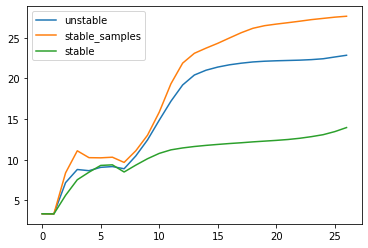

In [30]:
# validation over rollouts
legend = []
for variant in trained_learners.keys():
    learner = trained_learners[variant]
    plt.plot(learner.rollout_validation(X_long_horizon_rollouts, device='cpu'))
    legend.append(variant)
plt.legend(legend)
plt.show()

*** unstable ***


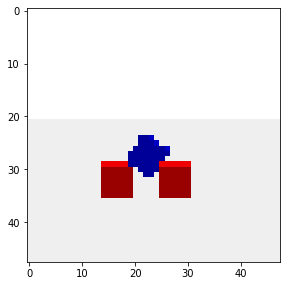

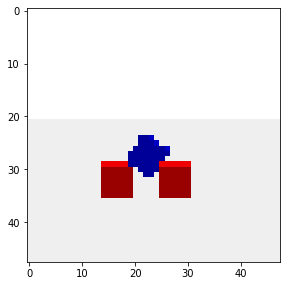

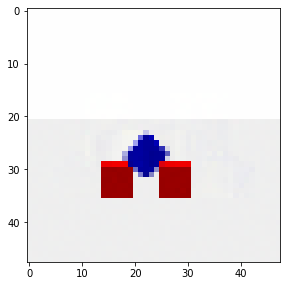

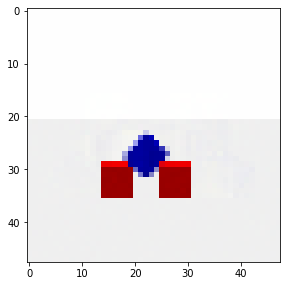

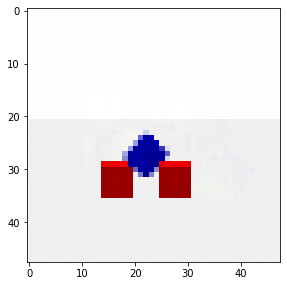

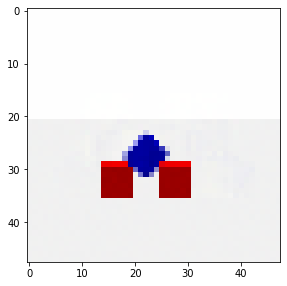

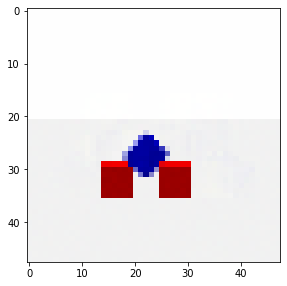

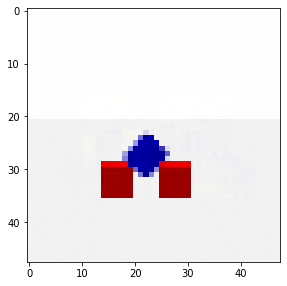

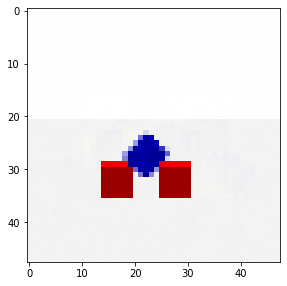

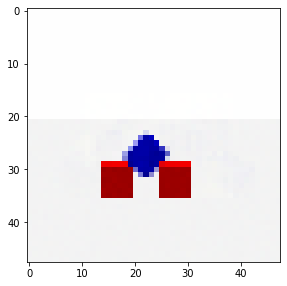

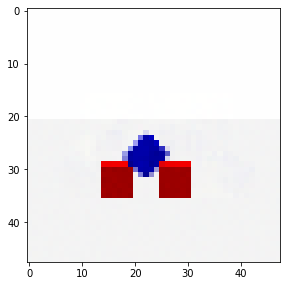

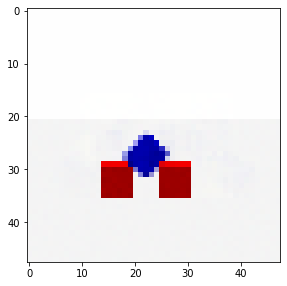

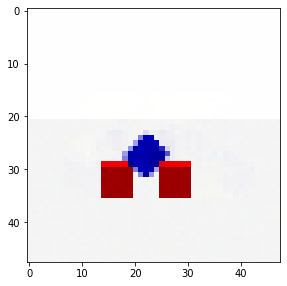

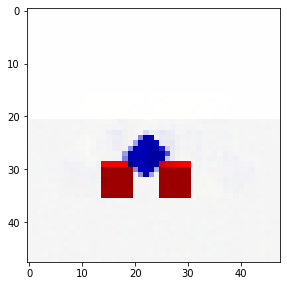

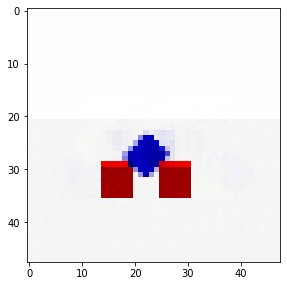

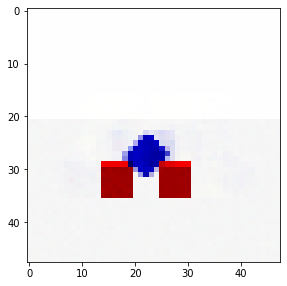

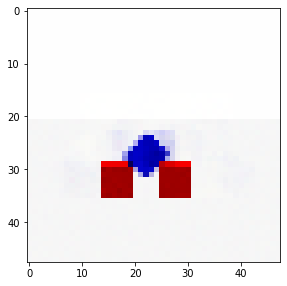

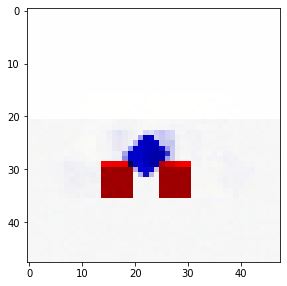

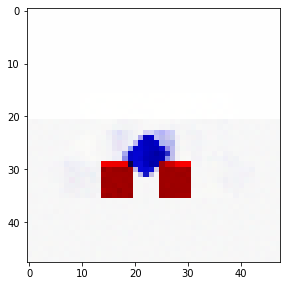

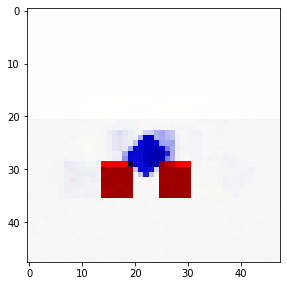

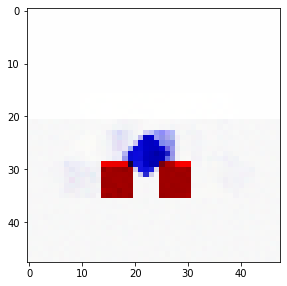

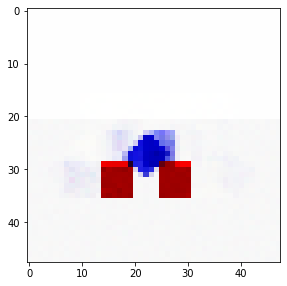

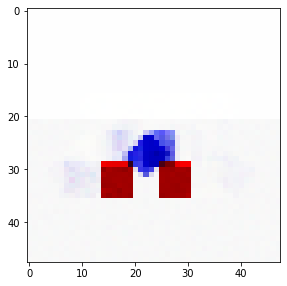

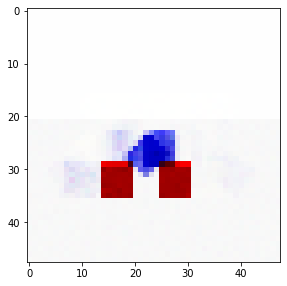

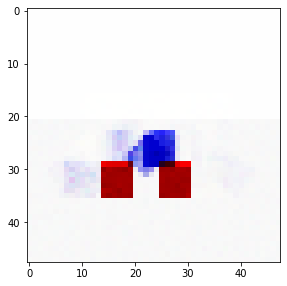

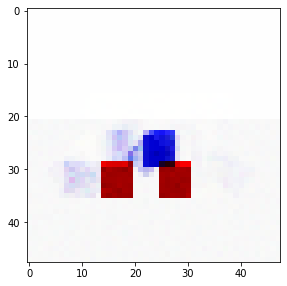

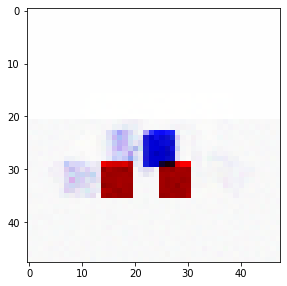

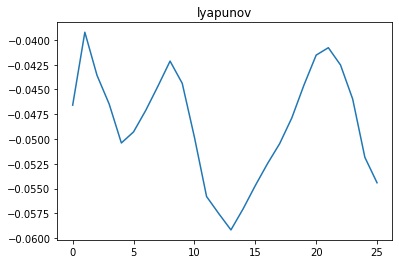

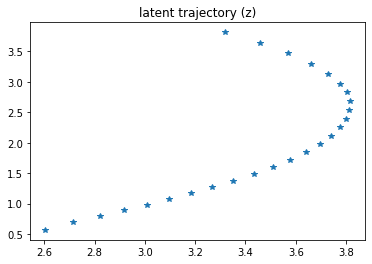

*** stable_samples ***


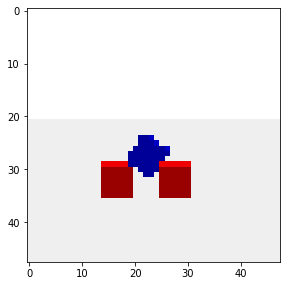

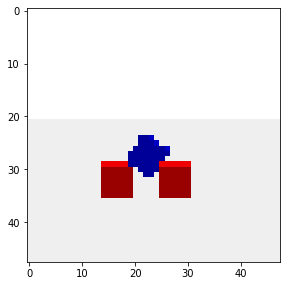

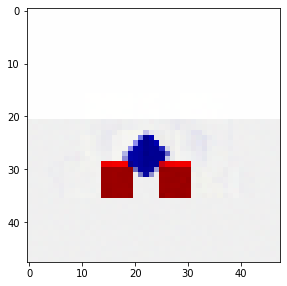

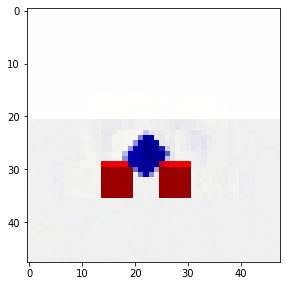

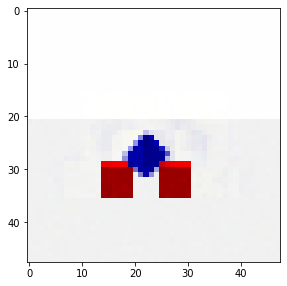

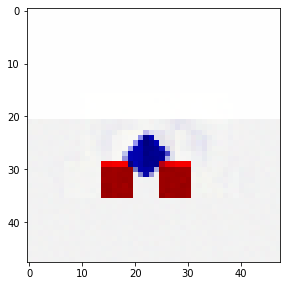

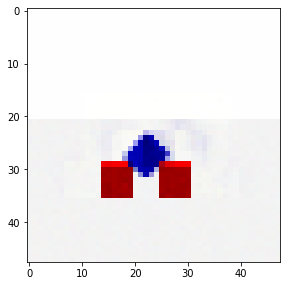

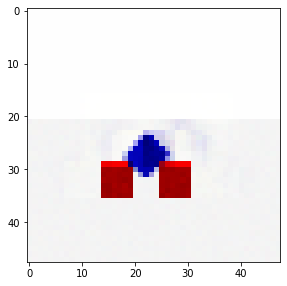

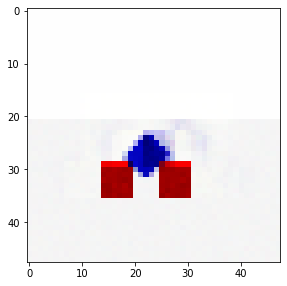

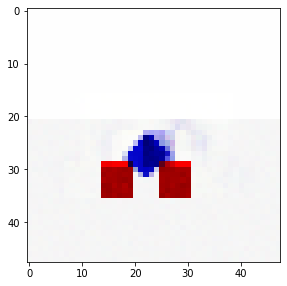

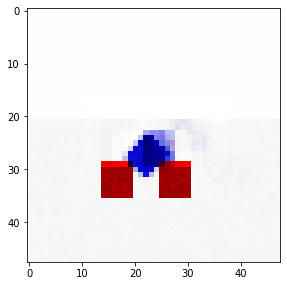

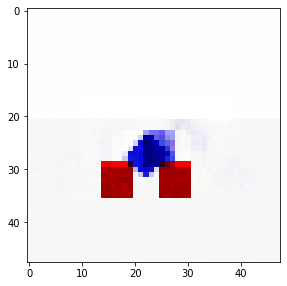

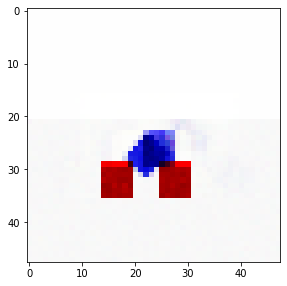

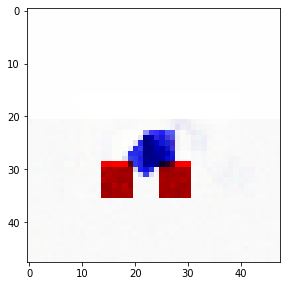

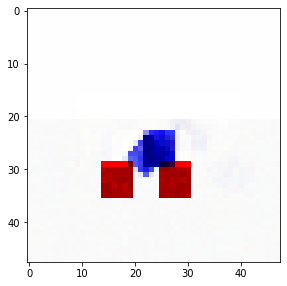

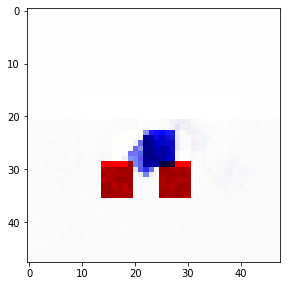

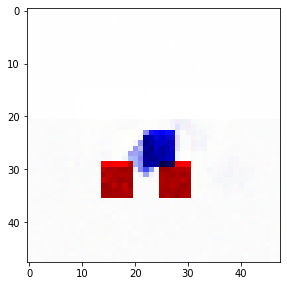

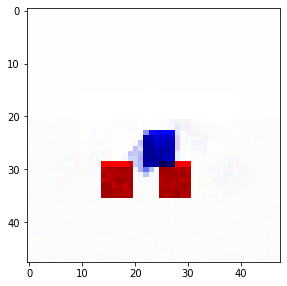

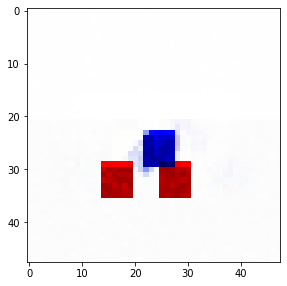

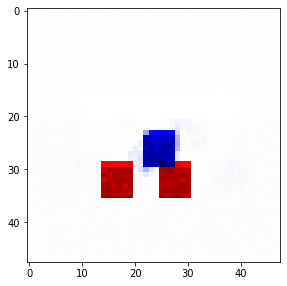

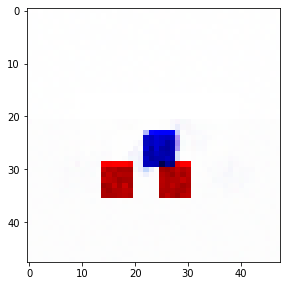

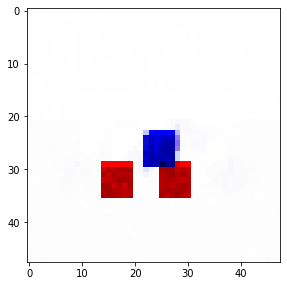

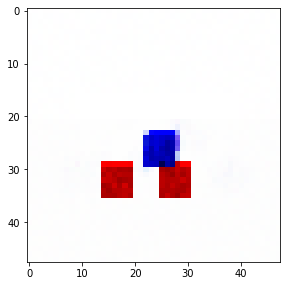

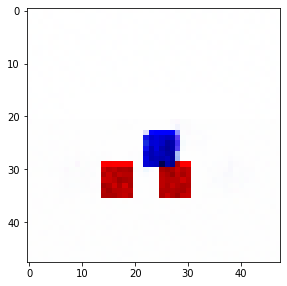

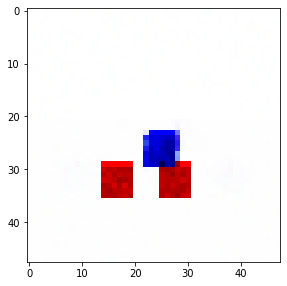

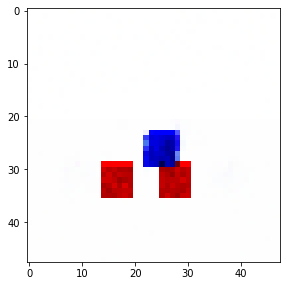

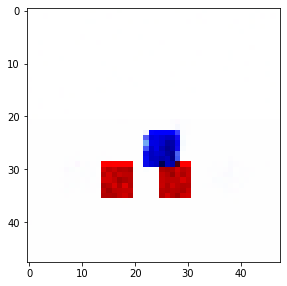

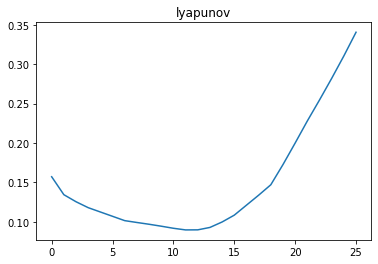

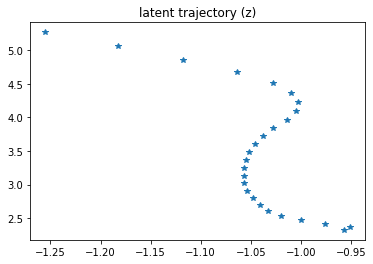

*** stable ***


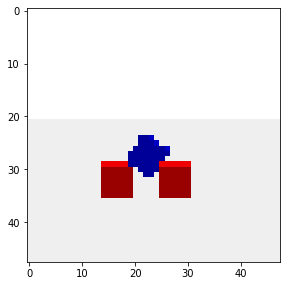

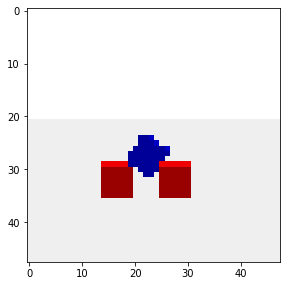

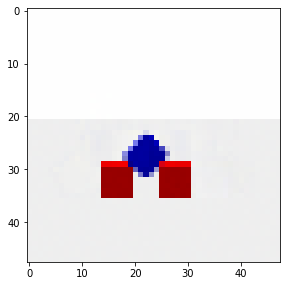

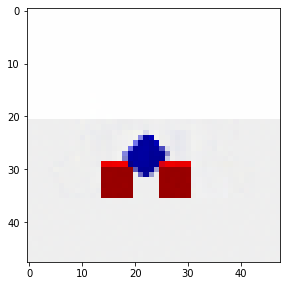

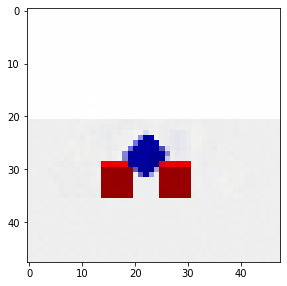

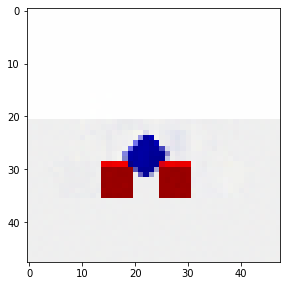

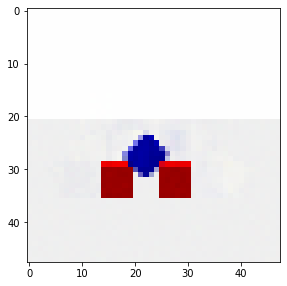

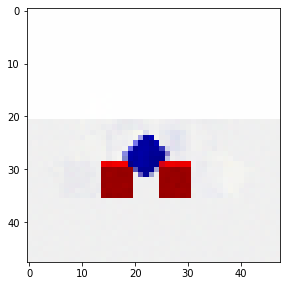

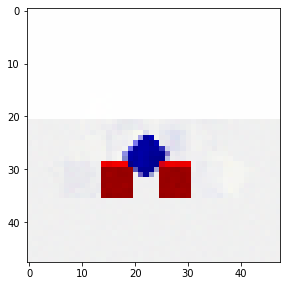

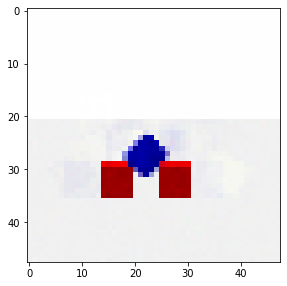

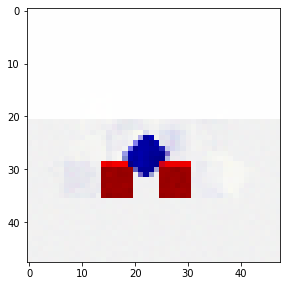

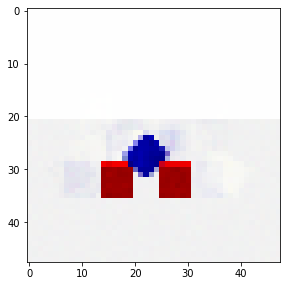

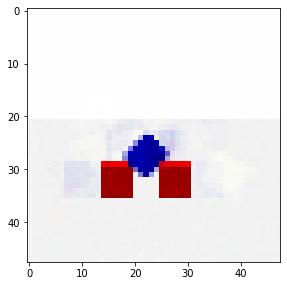

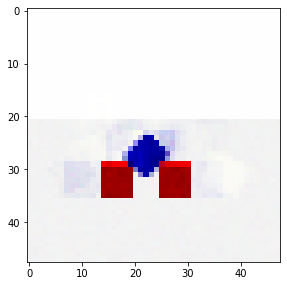

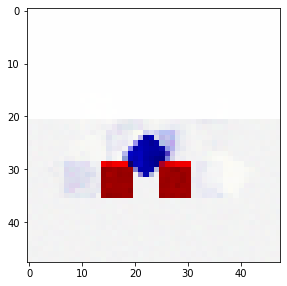

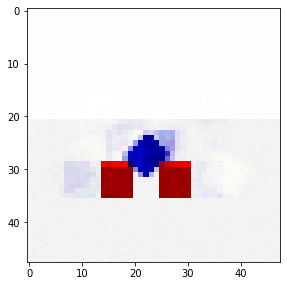

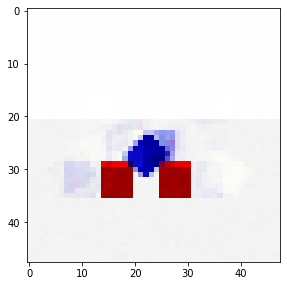

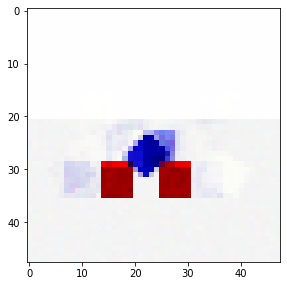

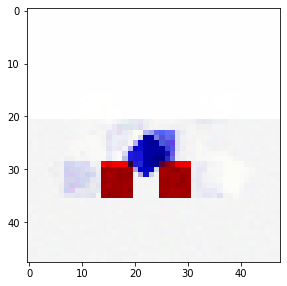

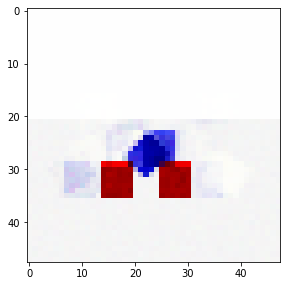

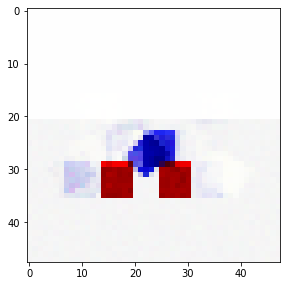

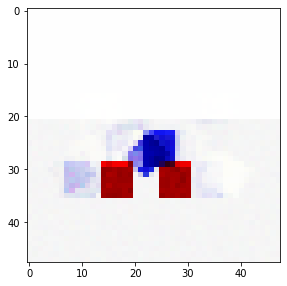

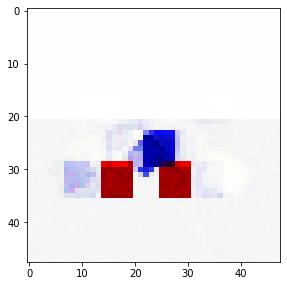

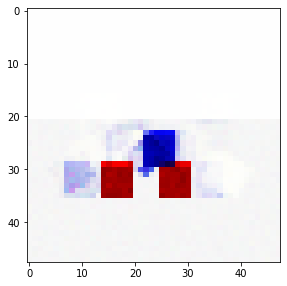

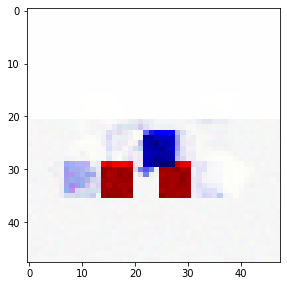

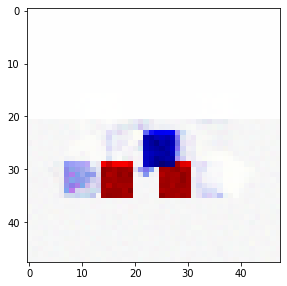

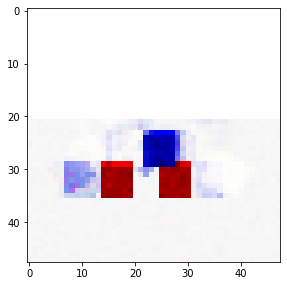

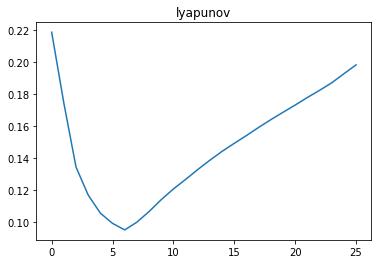

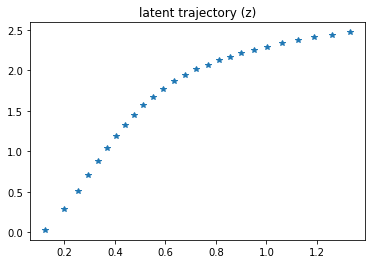

In [33]:
legend = []
# i = np.random.choice(X_data.shape[0], 1)[0]
# X0 = X_data[i, :]
i = np.random.choice(X_val.shape[0], 1)[0]
X0 = X_val[i, :]
for variant in trained_learners.keys():
# for variant in ['unstable', 'stable']:
    learner = trained_learners[variant]
    X_traj, V_traj, z_traj = learner.rollout(X0, learner.opt.dataset_N*5)
    print("*** " + variant + " ***")
    for n in range(X_traj.shape[0]):
        pybullet_data_generation.show_sample(X_traj[n, :])
    plt.plot(V_traj)
    plt.title("lyapunov")
    plt.show()
    plt.plot(z_traj[:,0], z_traj[:,1], "*")
    plt.title("latent trajectory (z)")
    plt.show()

In [ ]:
# train the lyapunov of the unstable system
unstable_learner = trained_learners["unstable"]
unstable_learner.reset_optimizer(lyapunov_only=True)
unstable_learner.opt.set_option("lyap_loss_freq", 1)
unstable_learner.opt.set_option("lyap_pos_loss_at_samples_weight", 1)
unstable_learner.opt.set_option("lyap_der_loss_at_samples_weight", 1)
unstable_learner.opt.set_option("lyap_pos_loss_weight", 1)
unstable_learner.opt.set_option("lyap_der_loss_weight", 1)

In [ ]:
# saving the new lyapunov
unstable_learner.save(os.path.join(folder, variant + "_trained_lyapunov"))

In [ ]:
# compute adversarial examples for the unstable system
unstable_learner.opt.set_option("lyap_loss_optimal", True)
z_adv_pos, z_adv_der = unstable_learner.adversarial_samples()
z_adv = torch.cat((z_adv_pos, z_adv_der), dim=0)
print(z_adv)

In [ ]:
stable_learner = trained_learners["stable"]
stable_learner.opt.set_option("lyap_loss_optimal", True)
z_adv_pos, z_adv_der = stable_learner.adversarial_samples()
z_adv = torch.cat((z_adv_pos, z_adv_der), dim=0)
print(z_adv)

In [ ]:
legend = []
for i in range(z_adv.shape[0]):
    print("adversarial sample: " + str(i))
    z0 = z_adv[i, :]
    X0 = unstable_learner.decoder.forward(z0.unsqueeze(0))[0, :]
    for variant in trained_learners.keys():
        learner = trained_learners[variant]
        X_traj, V_traj, z_traj = learner.rollout(X0, learner.opt.long_horizon_N)
        print("*** " + variant + " ***")
        for n in range(X_traj.shape[0]):
            pybullet_data_generation.show_sample(X_traj[n, :])
        plt.plot(V_traj)
        plt.title("lyapunov")
        plt.show()
    print("************")